In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Demo of FGSM attacks vs FGN and Classical networks
# both targeted and untargeted 
# heavily modified from: https://blog.ycombinator.com/how-adversarial-attacks-work/

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

countdown               Sun Jul 12 00:38:50 2020  418.87.01
[0] GeForce RTX 2080 Ti | 45'C,   0 % |  6021 / 10989 MB | felix(775M) felix(5235M)
[1] GeForce RTX 2080 Ti | 52'C,   0 % |  2744 / 10988 MB | felix(1013M) felix(775M) felix(775M) root(169M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# load MNIST data
batch_sizefor_train = 10000
batch_size_for_val = 10000
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=batch_sizefor_train,
                                                                                   batch_size_for_val=batch_size_for_val)

In [9]:
# load data by batch
for cln_data, true_label in mnist_val_loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

In [10]:
model_path = '../Experiments/sample_models/'
classic_model_path = '../Experiments/sample_models/sample_classic_full.pth'
fgn_model_path = '../Experiments/sample_models/'
fgn_model_path = '../Experiments/sample_models/sample_FGN_full.pth'

In [11]:
# load classic model
classic_model = torch.load(classic_model_path)
classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
# quick eval
# loss functions for the classic net      
cent_loss_func = fgnh.def_classical_cross_ent_loss()
pred_func = fgnh.cross_ent_pred_accuracy

print('Classic Model over MNIST Train')
_ = fgnh.test(classic_model, mnist_train_loader, cent_loss_func,
                               pred_func=pred_func, verbose=True)

print('Classic Model over MNIST Val')
_ = fgnh.test(classic_model, mnist_val_loader, cent_loss_func,
                               pred_func=pred_func, verbose=True)

Classic Model over MNIST Train
Test set - Average loss: 0.0318, Accuracy: 49509/50000 (99%)
Classic Model over MNIST Val
Test set - Average loss: 0.0932, Accuracy: 9739/10000 (97%)


In [13]:
# load fgn model
fgn_model = torch.load(fgn_model_path)

In [14]:
# # dict load
# hidden_layer_sizes = [32,32]
# drop_p = 0.2
# covar_type = 'diag'
# ordinal = float(5.)
# non_lin =  False
# fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
#                                      covar_type=covar_type, ordinal=ordinal, non_lin=non_lin)

# dict_path =  "../Experiments/sample_models/sample_fgn_state_dict.pth"
# fgn_model.load_state_dict(state_dict=torch.load(dict_path))

In [15]:
fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [16]:
# convert?
fgnl.convert_classic_to_fgn(classic_model, fgn_model, init_factor=2e0)

In [17]:
# quick eval
# print('with FGN random_eval OFF')
print('FGN Model over MNIST Train')
_ = fgnh.test(fgn_model, mnist_train_loader, cent_loss_func,
                               pred_func=pred_func, verbose=True)

print('FGN Model over MNIST Val')
_ = fgnh.test(fgn_model, mnist_val_loader, cent_loss_func,
                               pred_func=pred_func, verbose=True)

# fgn_model.set_random_eval(True)
# print('with FGN random_eval ON')
# print('FGN Model over MNIST Train')
# _ = fgnh.test(fgn_model, mnist_train_loader, cent_loss_func,
#                                pred_func=pred_func, verbose=True)

# print('FGN Model over MNIST Val')
# _ = fgnh.test(fgn_model, mnist_val_loader, cent_loss_func,
#                                pred_func=pred_func, verbose=True)

FGN Model over MNIST Train
Test set - Average loss: 0.0432, Accuracy: 49468/50000 (99%)
FGN Model over MNIST Val
Test set - Average loss: 0.0896, Accuracy: 9736/10000 (97%)


In [18]:
# set models to eval mode
classic_model.eval()
fgn_model.eval()

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [19]:
def draw_result(model, img, noise, adv_img):
    nrows = 2
    ncols = 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 4))
    orig_class, attack_class = fgnh.get_class_from_pred(model, img), fgnh.get_class_from_pred(model, adv_img)
    
    ax[0,0].imshow(img.cpu().numpy(), cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    ax[0,0].set_title('Original image: {}'.format(orig_class))
    ax[0,1].imshow(adv_img, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    ax[0,1].set_title('Adversarial example: {}'.format(attack_class))
    
    ax[1,0].imshow(noise, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    ax[1,0].set_title('Attacking noise')
    ax[1,1].imshow(noise, cmap=plt.cm.get_cmap('Greys'))
    ax[1,1].set_title('Attacking noise (Exagerated Contrast)')
    
    for a in ax.flat:
        a.set_axis_off()
    plt.tight_layout()
    plt.show()

In [20]:
### PART 1: untargeted FGSM attack

In [21]:
# values used for other things
# minimum/maximum pixel value post normalization, from train dataset
min_pix = -0.4242129623889923095703125
max_pix =  2.8214867115020751953125000
# mean and std of train set
train_mean = -0.0000061691193877777550369501113891601562500000000
train_std = 0.999999344348907470703125000000

In [71]:
# attack params
input_data = cln_data[40]
steps = 1
max_noise = (max_pix-min_pix)*35/128
step_size = max_noise

In [72]:
### Attack the classic net
classic_adv_img, classic_adv_noise, classic_results = fgnl.FGSM_attack_untargeted(model=classic_model, input_data=input_data,
                                                                                  data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.99,
                                                 verbose=True)
print(classic_results)

Step: 0
Step: 1
Early stopping at step 1 with confidence 0.9967656135559082:
{'steps': 1, 'confidence': 0.9967656}


In [73]:
### Attack the fgn net
fgn_model.set_random_eval(True)
fgn_adv_img, fgn_adv_noise, fgn_results = fgnl.FGSM_attack_untargeted(model=fgn_model, input_data=input_data,
                                                                      data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.99,
                                                 verbose=True)
print(fgn_results)

Step: 0
Step: 1
Grad zero found. Taking Random Step
Found wrong class 0 at step 1 with confidence 0.10000000149011612.
Attempting to increase confidence
{'steps': 1, 'confidence': 0.1}


Classic Net attack: {'steps': 1, 'confidence': 0.9967656}


<IPython.core.display.Javascript object>


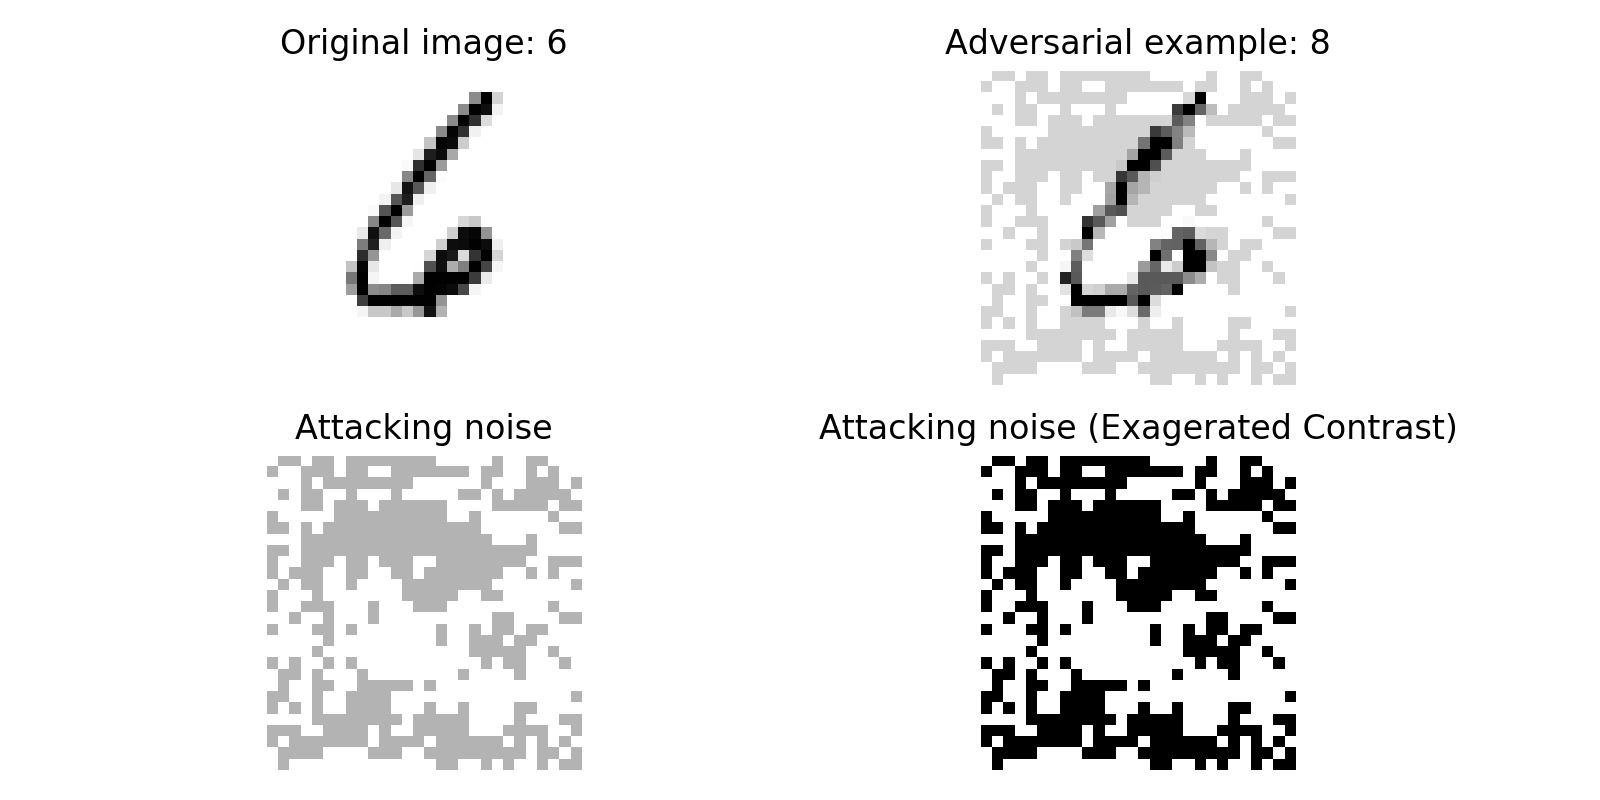

FGN attack: {'steps': 1, 'confidence': 0.1}


<IPython.core.display.Javascript object>


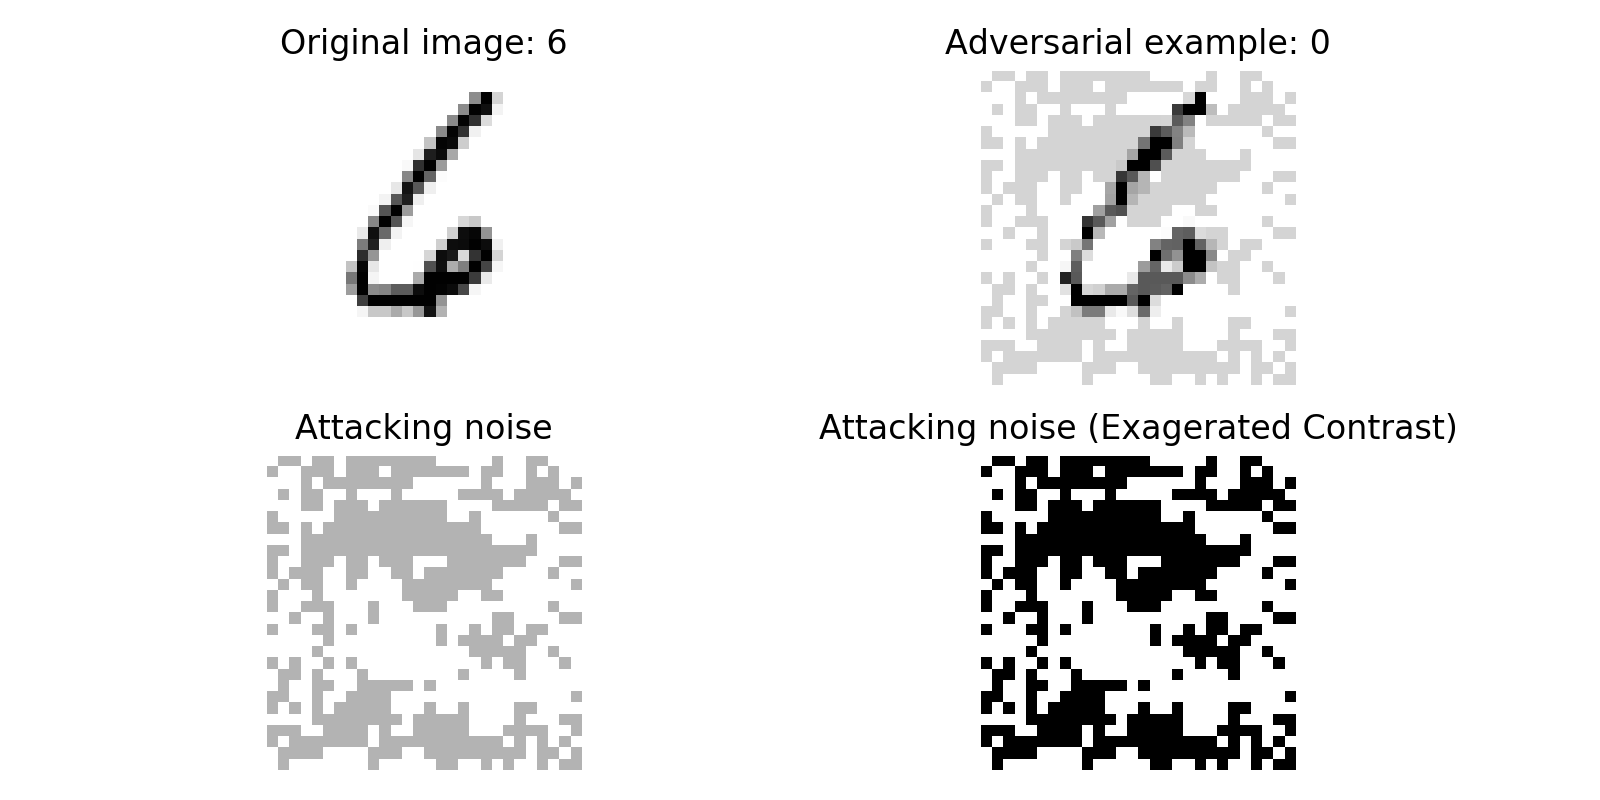

In [74]:
print("Classic Net attack:", classic_results)
draw_result(classic_model, input_data, classic_adv_noise, classic_adv_img)
print("FGN attack:", fgn_results)
draw_result(fgn_model, input_data, fgn_adv_noise, fgn_adv_img)

In [42]:
### PART 2: targeted FGSM attack

In [88]:
# attack params
# input_data = cln_data[1]

# max_noise = float(max_pix-min_pix)/128.0
# step_size = float(max_pix-min_pix)/256.0
# steps = 10

target_class = 8

In [89]:
### Attack the classic net
classic_adv_img, classic_adv_noise, classic_results = fgnl.FGSM_attack_targeted(model=classic_model, input_data=input_data,
                                                                                target_class=target_class, data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.99,
                                                 verbose=True)
print(classic_results)

Step: 0
Step: 1
Found target class 8 at step 1 with confidence 0.9837502837181091.
Attempting to increase confidence
{'steps': 1, 'confidence': 0.9837503}


In [90]:
### Attack the fgn net
fgn_model.set_random_eval(True)
fgn_adv_img, fgn_adv_noise, fgn_results = fgnl.FGSM_attack_targeted(model=fgn_model, input_data=input_data,
                                                                    target_class=target_class, data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.99,
                                                 verbose=True)
print(fgn_results)

Step: 0
Step: 1
{'steps': 1, 'confidence': -1.0}


Classic Net attack: {'steps': 1, 'confidence': 0.9837503}


<IPython.core.display.Javascript object>


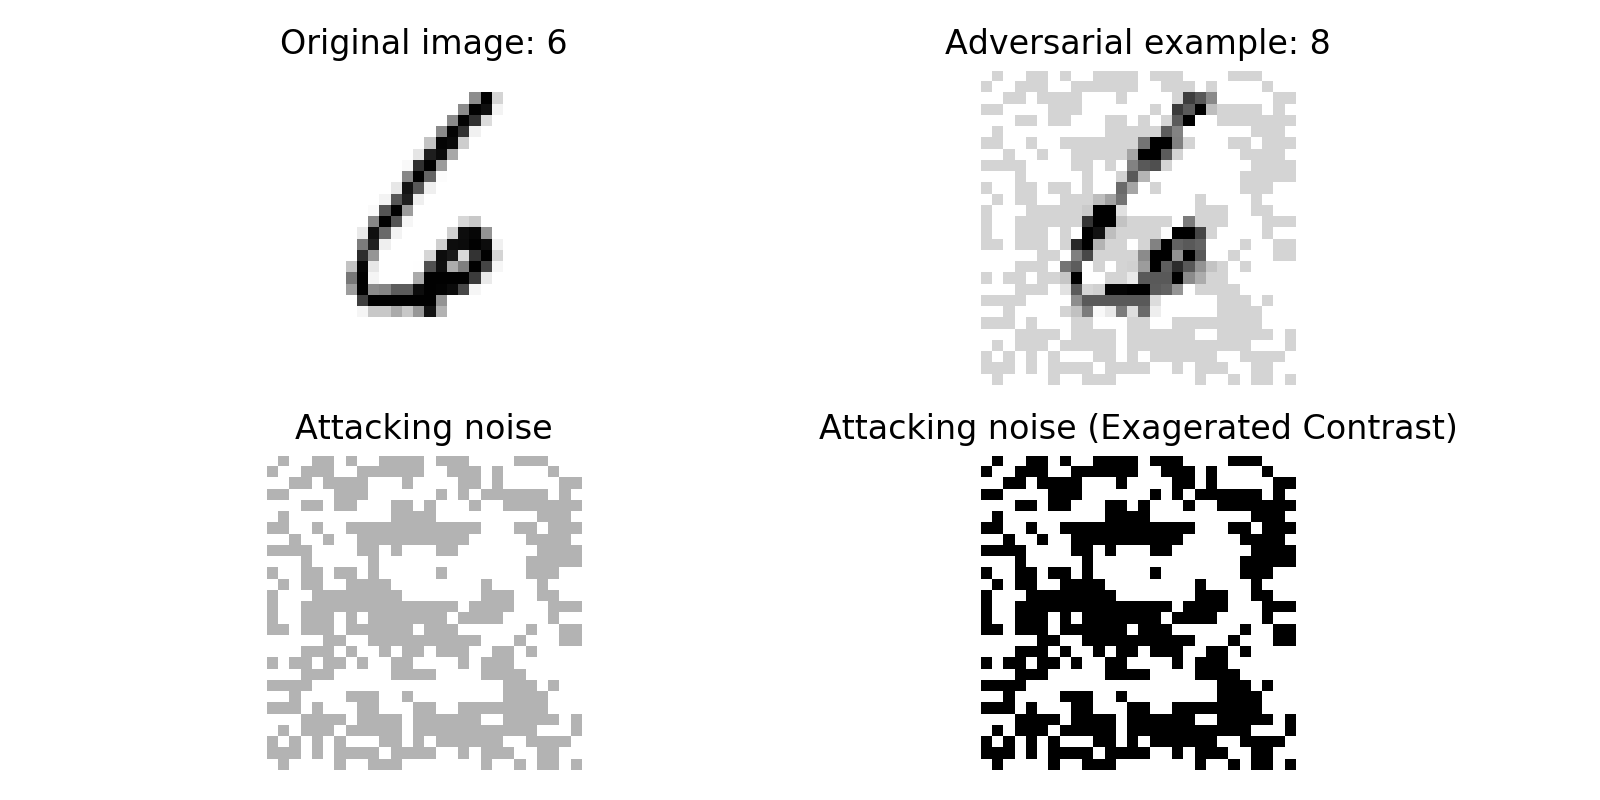

FGN attack: {'steps': 1, 'confidence': -1.0}


<IPython.core.display.Javascript object>


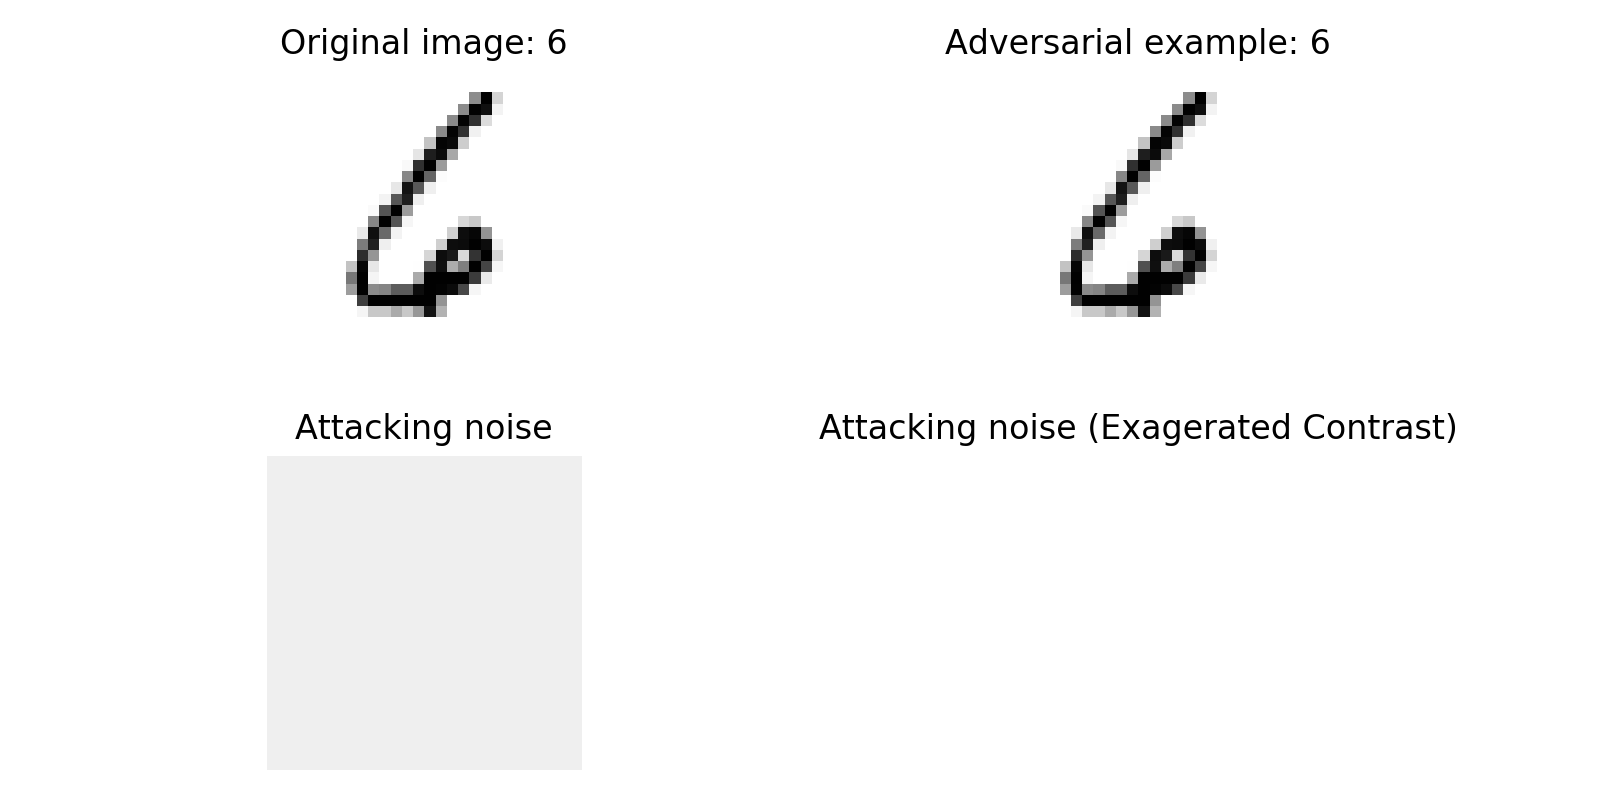

In [91]:
print("Classic Net attack:", classic_results)
draw_result(classic_model, input_data, classic_adv_noise, classic_adv_img)
print("FGN attack:", fgn_results)
draw_result(fgn_model, input_data, fgn_adv_noise, fgn_adv_img)

In [47]:
# ### Extra: how does random eval affect the attack on the fgn?
# fgn_model.set_random_eval(False)
# fgn_adv_img, fgn_adv_noise, fgn_results = fgnl.FGSM_attack_targeted(model=fgn_model, input_data=input_data,
#                                                                     target_class=target_class, data_bounds=(min_pix, max_pix),
#                                                  max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
#                                                  step_size=step_size, steps=steps, confidence_req=0.99,
#                                                  verbose=True)
# print(fgn_results)

In [48]:
### how does FGN do on classic adv noise
# cur_out = fgn_model(classic_adv_img.to(device))
# print(torch.softmax(cur_out,1))

In [49]:
# cur_out = classic_model(classic_adv_img.to(device))
# print(torch.softmax(cur_out,1))